In [1]:
# imports
import pandas as pd
import numpy as np
import sklearn as sk
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn import tree
from sklearn.model_selection import GridSearchCV
#import nbimporter
#from funcs import *
from xgboost import XGBRegressor
import copy

In [2]:
def get_forw(i, winds, plot_fig = False):
    X = np.array(data['series'+str(i)])
    test = X[(n-test_ratio):n]
    
    MSE_dif = 10
    cur_wind = -1
    train_t = -1
    test_t = -1
    regr_res = -1
    
    for wind in winds:
        m=n-wind
        ntest = int((m-test_ratio+1)*cross_test)
        ntrain = (m-test_ratio+1)-ntest
        Xt = np.copy(X[0:wind])
        for i in range(1,m+1):
            Xt =  np.vstack((Xt,X[i:(i+wind)]))
        train_loc = Xt[0:ntrain]
        test_loc = Xt[ntrain:(m-test_ratio+1)]
        regr = linear_model.LinearRegression()
        regr.fit(train_loc[:,0:(wind-1)], train_loc[:,wind-1])
        res_loc = regr.predict(test_loc[:,0:(wind-1)])
        mse_loc = sk.metrics.mean_squared_error(res_loc, test_loc[:,wind-1])
        if (mse_loc < MSE_dif):
            MSE_dif = mse_loc
            cur_wind = wind
            train_t = np.copy(Xt[0:(m-test_ratio+1)])
            test_t = np.copy(Xt[(m-test_ratio+1):(m+1)])
            regr_res = regr

    regr_res.fit(train_t[:,0:(cur_wind-1)], train_t[:,cur_wind-1])
    res_dif = regr_res.predict(test_t[:,0:(cur_wind-1)])
  
    return(np.array([sk.metrics.mean_squared_error(res_dif, test), cur_wind]))

In [3]:
def get_mse(winds, print_msg = True):
    MSE = get_forw(1,winds)
    for i in range(2,101):
        MSE = np.vstack((MSE,get_forw(i,winds)))
        # if (print_msg):
        # print("Linear regression: MSE={}".format(np.round(np.mean(MSE),3)))
    return([np.mean(MSE[:,0]),MSE])

In [4]:
def get_upper_bound(i, plot_fig = False):
    X = np.array(data['series'+str(i)])
    res = X[(n-test_ratio-1):(n-1)]
    test = X[(n-test_ratio):n]
    MSE = sk.metrics.mean_squared_error(res, test)
   
    if (plot_fig):
        plt.plot(res)
        plt.plot(test)
        plt.show()

    return(MSE)

In [5]:
def get_upper_bound_mse(plot_fig = False):
    get_upper_bound(1,plot_fig)
    MSE = []
    for i in range(1,101):
        MSE = np.append(MSE, get_upper_bound(i))
    #print("Linear regression: upper bound MSE={}".format(np.round(np.mean(MSE),3)))
    return(np.mean(MSE))

In [6]:
def get_lower_bound(i):
    X = np.array(data['series'+str(i)])
    test = X[(n-test_ratio):n]
    X_dif = X[1:n]-X[0:(n-1)]
    test_dif = X_dif[(n-test_ratio-1):(n-1)]
    opt = np.var(test_dif)
    opt_wind = 0
    for wind in range(1,n-test_ratio-1):
        test_dif = np.copy(X_dif[(n-test_ratio-1):(n-1)])
        for i in range(0,test_ratio):
            test_dif[i] = test_dif[i] - np.mean(X_dif[(n-test_ratio-1 + i-wind):(n-test_ratio-1 + i)])
        tmp = np.var(test_dif)
        if (tmp < opt):
            opt = tmp
            opt_wind = wind

    return([opt,opt_wind])

In [7]:
def get_lower_bound_mse():
    MSE = []
    winds = []
    for i in range(1,101):
        tmp = get_lower_bound(i)
        MSE = np.append(MSE, tmp[0])
        winds = np.append(winds, tmp[1])
    #print("Linear regression: lower bound MSE={}".format(np.round(np.mean(MSE),3)))
    return([np.mean(MSE), winds])

In [8]:
def get_bounds():
    lower_bound = get_lower_bound_mse()
    print("bounds MSE = ({}, {})".format(*[np.round(lower_bound[0],3),np.round(get_upper_bound_mse(),3)]))
    return(lower_bound[1])

In [133]:
data = pd.read_csv("series1/linear_trend.csv")

In [135]:
data = pd.read_csv("series1/difficult_trend.csv")

In [ ]:
data = pd.read_csv("series1/white_noise.csv")

In [ ]:
data = pd.read_csv("series1/trend_whiteNoise.csv")

In [ ]:
data = pd.read_csv("series1/difficultTrend_whiteNoise.csv")

0.0011641288222876726


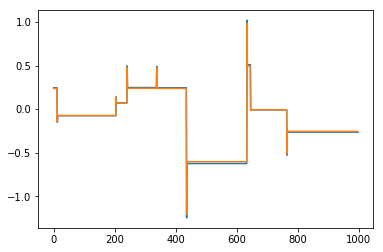

[0.0, array([0.96631657])]


In [139]:
X = np.array(data['series1'])
#print(data['series1'])
#sk.preprocessing.scale(
X_dif = X[1:n]-X[0:(n-1)]
#print(X_dif)
plt.plot(X_dif)
#plt.show()
wind = 2
m=n-wind
Xt = X_dif[0:wind]
for i in range(1,m):
    Xt =  np.vstack((Xt,X_dif[i:(i+wind)]))
X = Xt[0:698,0:(wind-1)]
Y = Xt[0:698,wind-1]
Xtest = Xt[698:998,0:(wind-1)]
Ytest = Xt[698:998,wind-1]
regr = linear_model.LinearRegression(fit_intercept=False).fit(X, Y)
regr.predict(Xtest)
print(sk.metrics.mean_squared_error(regr.predict(Xtest),Ytest))
plt.plot(regr.predict(Xt[:,0:(wind-1)]))
plt.show()
print([regr.intercept_,regr.coef_])
#Xtest[:,0]-Ytest

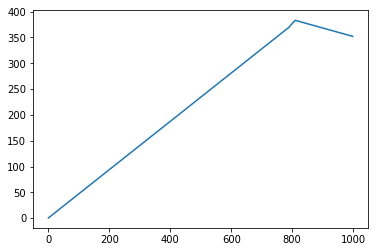

In [17]:
plt.plot(data['series2'])
plt.show()

In [117]:
def get_dif(i,winds, meth, plot_fig = False):
    X = np.array(data['series'+str(i)])
    X_dif = X[1:n]-X[0:(n-1)]

    MSE_dif = 10
    cur_wind = -1
    train_t = -1
    test_t = -1
    regr_res = -1
    params = []
    
    for wind in winds:
        #print(wind, end = '  ')
        m=n-wind
        Xt = X_dif[0:wind]
        for i in range(1,m):
            Xt =  np.vstack((Xt,X_dif[i:(i+wind)]))
        train_loc = np.copy(Xt[0:(m-test_ratio)])
        regr = meth(train_loc[:,0:(wind-1)], train_loc[:,wind-1])
        mse_loc = regr[2]
        #sk.metrics.mean_squared_error(regr[0].predict(train_loc[:,0:(wind-1)]), train_loc[:,wind-1]) 
        if (mse_loc < MSE_dif):
            MSE_dif = mse_loc
            cur_wind = wind
            test_t = np.copy(Xt[(m-test_ratio):m])
            regr_res = regr[0]
            params = regr[1]
        
    res_dif = regr_res.predict(test_t[:,0:(cur_wind-1)])
    
    if (plot_fig):
        plt.plot(res_dif+X[(n-test_ratio-1):(n-1)]) # res
        plt.plot(X[(n-test_ratio):n]) # test
        plt.show()
    #for i in range(0,300):
    #    print((res_dif[i]-test_t[i,cur_wind-1])**2)
    return(np.append(np.array([sk.metrics.mean_squared_error(res_dif, test_t[:,cur_wind-1]), 
                               MSE_dif, cur_wind]), params))

In [4]:
def get_dif_mse(winds, meth, n_ser = 101, print_msg = True):
    #print(1)
    #print(end = '  ')
    MSE = get_dif(1, winds, meth)
    #print()
    for i in range(2,n_ser):
        #print(i)
        #print(end = '  ')
        MSE = np.vstack((MSE,get_dif(i, winds, meth)))
        #print()
        # if (print_msg):
        # print("Linear regression by differences: MSE_dif={}".format(np.round(np.mean(MSE),3)))
    return(MSE)

In [80]:
def lin_regr(X, Y):
    regr = linear_model.LinearRegression(fit_intercept=False)
    params = {'n_jobs': [-1]}
    dt_clf = GridSearchCV(regr, params, cv=3, n_jobs=-1, iid=False, 
                          verbose = 0, scoring='neg_mean_squared_error').fit(X, Y)
    return [dt_clf.best_estimator_, 0, -dt_clf.best_score_]

In [38]:
def lasso(X, Y):
    regr = sk.linear_model.LassoCV(verbose=False,n_jobs=-1, cv=3, fit_intercept=False).fit(X, Y)
    return [regr, regr.alpha_, min(np.mean(regr.mse_path_,1))]

In [39]:
def tree(X, Y):
    regr = sk.tree.DecisionTreeRegressor()
    params = { 'max_depth': range(1,6) }
    dt_clf = GridSearchCV(regr, params, cv=3, n_jobs=-1, iid=False, verbose = 0, 
                          scoring='neg_mean_squared_error').fit(X, Y)
    return [dt_clf.best_estimator_, dt_clf.best_params_['max_depth'], -dt_clf.best_score_]

In [40]:
def boost(X, Y):
    regr = XGBRegressor(n_jobs=-1)
    params = {
        'n_estimators' : range(20,121,20),
        'max_depth': range(1,4)
    }
    dt_clf = GridSearchCV(regr, params, cv=3, n_jobs=-1, iid=False, verbose = 0
                          , scoring='neg_mean_squared_error').fit(X, Y)
    return [dt_clf.best_estimator_,np.array([dt_clf.best_params_['n_estimators'], 
                                             dt_clf.best_params_['max_depth']]), -dt_clf.best_score_]

# 1 тренд без шума

In [150]:
# data, params
data = pd.read_csv("series1/linear_trend.csv")
n = data.shape[0]
test_perc = 0.3
test_ratio = int(test_perc*n)
cross_test = 0.35

### Linear regression

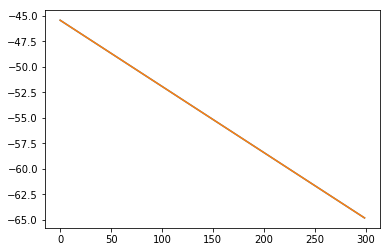

Linear regression: MSE=0.0, train_MSE=0.0, wind=2


In [64]:
res = get_dif(1,[2], lin_regr, True)
print("Linear regression: MSE={}, train_MSE={}, wind={}".format(np.round(res[0],3), np.round(res[1],3), int(res[2])))

### Lasso

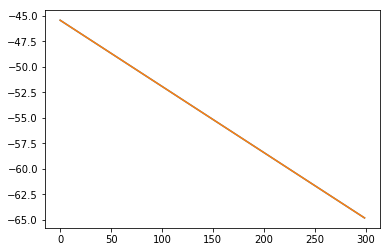

Linear regression: MSE=0.0, train_MSE=0.0, wind=2, alpha=0.0


In [445]:
res = get_dif(1,[2], lasso, True)
print("Linear regression: MSE={}, train_MSE={}, wind={}, alpha={}".format(np.round(res[0],3), np.round(res[1],3), int(res[2]), round(res[3],3)))

### Tree

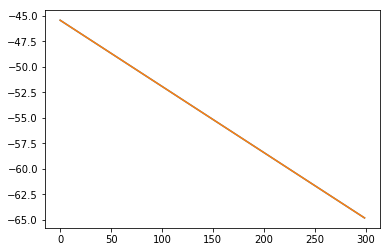

Linear regression: MSE=0.0, train_MSE=0.0, wind=2, depth=1


In [446]:
res = get_dif(1,[2], tree, True)
print("Linear regression: MSE={}, train_MSE={}, wind={}, depth={}".format(np.round(res[0],3), 
    np.round(res[1],3), int(res[2]), int(res[3])))

### XGBoost

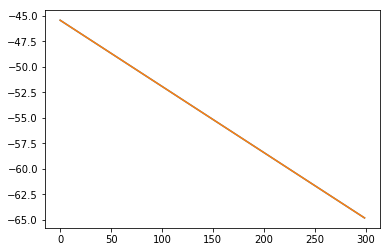

Linear regression: MSE=0.0, train_MSE=0.0, wind=2, estim=150, depth=1


In [447]:
res = get_dif(1,[2], boost, True)
print("Linear regression: MSE={}, train_MSE={}, wind={}, estim={}, depth={}".format(np.round(res[0],3), 
    np.round(res[1],3), int(res[2]), int(res[3]), int(res[4])))

# Белый шум

In [145]:
data = pd.read_csv("series1/white_noise.csv")

arr_name = []
arr_train = []
arr_test = []
arr_var = []

### ошибка по предыдущему значению

In [146]:
wn_min_err = []
for i in range(1,101):
    wn_min_err.append(round(sk.metrics.mean_squared_error(data['series'+str(i)][(n-test_ratio):n], 
                                    data['series'+str(i)][(n-test_ratio-1):(n-1)]), 3))
np.mean(wn_min_err)

1.01068

### Linear regression

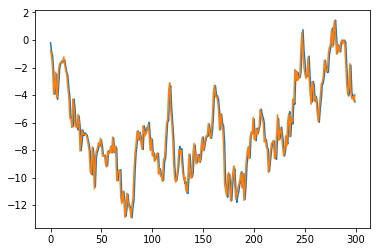

In [449]:
res = get_dif(1,[15], lin_regr, True)

In [131]:
regr_wn_mse = get_dif_mse([5], lin_regr)

In [132]:
print("Linear regression: MSE={}+-{}, train_MSE={}".format(np.round(np.mean(regr_wn_mse[:,0]),3),
    np.round(2*np.var(regr_wn_mse[:,0]),3), np.round(np.mean(regr_wn_mse[:,1]),3)))

Linear regression: MSE=1.018+-0.017, train_MSE=1.0


In [489]:
print("Linear regression: MSE={}+-{}, train_MSE={}".format(np.round(np.mean(regr_wn_mse[:,0]),3),
    np.round(2*np.var(regr_wn_mse[:,0]),3), np.round(np.mean(regr_wn_mse[:,1]),3)))

Linear regression: MSE=1.034+-0.018, train_MSE=1.024


In [501]:
arr_name.append('Lin regr')
arr_train.append(np.round(np.mean(regr_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(regr_wn_mse[:,0]),3))
arr_var.append(np.round(np.var(regr_wn_mse[:,0]),3))

### Lasso

In [453]:
lasso_wn_mse = get_dif_mse([15], lasso)

In [493]:
print("Linear regression: MSE={}+-{}, train_MSE={}, mean_alpha={}".format(
    np.round(np.mean(lasso_wn_mse[:,0]),3), np.round(2*np.var(lasso_wn_mse[:,0]),3),
    np.round(np.mean(lasso_wn_mse[:,1]),3), np.round(np.mean(lasso_wn_mse[:,3]),3)))

Linear regression: MSE=1.013+-0.016, train_MSE=0.993, mean_alpha=0.064


In [502]:
arr_name.append('Lasso')
arr_train.append(np.round(np.mean(lasso_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(lasso_wn_mse[:,0]),3))
arr_var.append(np.round(np.var(lasso_wn_mse[:,0]),3))

### Tree

In [457]:
tree_wn_mse = get_dif_mse([15], tree)

In [496]:
print("Tree: MSE={}+-{}, train_MSE={}, mean_depth={}".format(np.round(np.mean(tree_wn_mse[:,0]),3), 
    np.round(2*np.var(tree_wn_mse[:,0]),3), np.round(np.mean(tree_wn_mse[:,1]),3), 
    np.round(np.mean(tree_wn_mse[:,3]),3)))

Tree: MSE=1.032+-0.017, train_MSE=1.015, mean_depth=1.02


In [503]:
arr_name.append('Tree')
arr_train.append(np.round(np.mean(tree_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(tree_wn_mse[:,0]),3))
arr_var.append(np.round(np.var(tree_wn_mse[:,0]),3))

### XGBoost

In [460]:
boost_wn_mse = get_dif_mse([15], boost)

In [509]:
print("Tree: MSE={}+-{}, train_MSE={}, mean_estim={}, mean_depth={}".format(np.round(np.mean(boost_wn_mse[:,0]),3), 
    np.round(2*np.var(boost_wn_mse[:,0]),3), np.round(np.mean(boost_wn_mse[:,1]),3), 
    np.round(np.mean(boost_wn_mse[:,3]),3), np.round(np.mean(boost_wn_mse[:,4]),3)))

Tree: MSE=1.028+-0.017, train_MSE=1.009, mean_estim=50.0, mean_depth=1.0


In [504]:
arr_name.append('XGBoost')
arr_train.append(np.round(np.mean(boost_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(boost_wn_mse[:,0]),3))
arr_var.append(np.round(np.var(boost_wn_mse[:,0]),3))

### Результаты

In [506]:
dic={'name':arr_name, 'train': arr_train, 'test': arr_test, 'var': arr_var}
df=pd.DataFrame(data=dic)
df

,name,train,test,var
0,Lin regr,1.024,1.034,0.009
1,Lasso,0.993,1.013,0.008
2,Tree,1.015,1.032,0.008
3,XGBoost,1.009,1.028,0.008


# Несколько трендов без шума

In [152]:
data = pd.read_csv("series1/difficult_trend.csv")

arr_name = []
arr_train = []
arr_test = []
arr_var = []

### Минимальная ошибка
##### $\sigma^2\lambda=0.25/200=0.00125$

### по предыдущему значению

In [158]:
wn_min_err = []
for i in range(1,101):
    X = np.array(data['series'+str(i)])
    X_dif = X[1:n]-X[0:(n-1)]
    wn_min_err.append(sk.metrics.mean_squared_error(X_dif[(n-test_ratio-1):(n-1)], 
                                    X_dif[(n-test_ratio-2):(n-2)]))
np.round(np.mean(wn_min_err),3)

0.009

### Linear regression

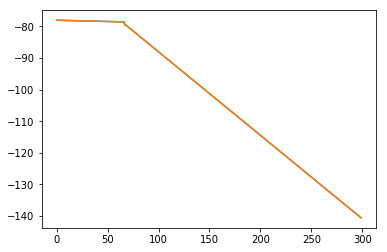

Linear regression: MSE=0.001, train_MSE=0.009, wind=2


In [47]:
res = get_dif(1, [2], lin_regr, True)
print("Linear regression: MSE={}, train_MSE={}, wind={}".format(np.round(res[0],3), np.round(res[1],3), 
    int(res[2])))

In [48]:
regr_wn_mse = get_dif_mse([2], lin_regr)

In [49]:
print("Linear regression: MSE={}+-{}, train_MSE={}".format(np.round(np.mean(regr_wn_mse[:,0]),3),
    np.round(2*np.var(regr_wn_mse[:,0]),3), np.round(np.mean(regr_wn_mse[:,1]),3)))

Linear regression: MSE=0.009+-0.0, train_MSE=0.014


In [51]:
arr_name.append('Lin regr')
arr_train.append(np.round(np.mean(regr_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(regr_wn_mse[:,0]),3))
arr_var.append(np.round(np.var(regr_wn_mse[:,0]),3))

### Lasso

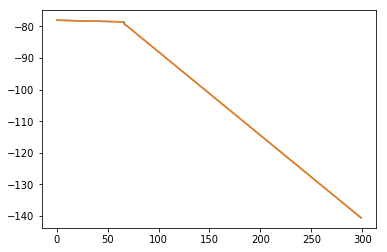

Linear regression: MSE=0.001, train_MSE=0.009, wind=2, alpha=0.0


In [52]:
res = get_dif(1,[2], lasso, True)
print("Linear regression: MSE={}, train_MSE={}, wind={}, alpha={}".format(np.round(res[0],3), 
    np.round(res[1],3), int(res[2]), round(res[3],3)))

In [53]:
lasso_wn_mse = get_dif_mse([2], lasso)

In [54]:
print("Linear regression: MSE={}+-{}, train_MSE={}, mean_alpha={}".format(
    np.round(np.mean(lasso_wn_mse[:,0]),3), np.round(2*np.var(lasso_wn_mse[:,0]),3),
    np.round(np.mean(lasso_wn_mse[:,1]),3), np.round(np.mean(lasso_wn_mse[:,3]),3)))

Linear regression: MSE=0.009+-0.0, train_MSE=0.014, mean_alpha=0.001


In [55]:
arr_name.append('Lasso')
arr_train.append(np.round(np.mean(lasso_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(lasso_wn_mse[:,0]),3))
arr_var.append(np.round(np.var(lasso_wn_mse[:,0]),3))

### Tree

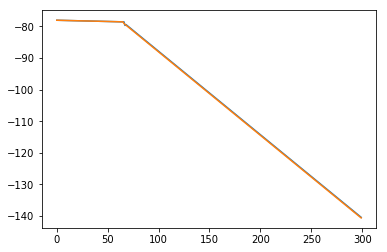

Linear regression: MSE=0.029, train_MSE=0.011, wind=2, depth=5


In [56]:
res = get_dif(1,[2], tree, True)
print("Linear regression: MSE={}, train_MSE={}, wind={}, depth={}".format(np.round(res[0],3), 
    np.round(res[1],3), int(res[2]), int(res[3])))

In [57]:
tree_wn_mse = get_dif_mse([2], tree)

In [58]:
print("Tree: MSE={}+-{}, train_MSE={}, mean_depth={}".format(np.round(np.mean(tree_wn_mse[:,0]),3), 
    np.round(2*np.var(tree_wn_mse[:,0]),3), np.round(np.mean(tree_wn_mse[:,1]),3), 
    np.round(np.mean(tree_wn_mse[:,3]),3)))

Tree: MSE=0.05+-0.02, train_MSE=0.051, mean_depth=3.3


In [59]:
arr_name.append('Tree')
arr_train.append(np.round(np.mean(tree_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(tree_wn_mse[:,0]),3))
arr_var.append(np.round(np.var(tree_wn_mse[:,0]),3))

### XGBoost

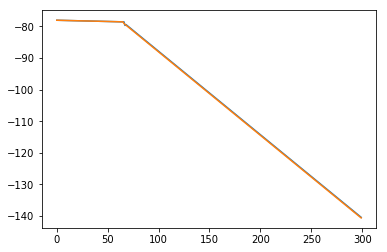

Linear regression: MSE=0.029, train_MSE=0.011, wind=2, estim=100, depth=3


In [60]:
res = get_dif(1,[2], boost, True)
print("Linear regression: MSE={}, train_MSE={}, wind={}, estim={}, depth={}".format(np.round(res[0],3), 
    np.round(res[1],3), int(res[2]), int(res[3]), int(res[4])))

In [61]:
boost_wn_mse = get_dif_mse([2], boost)

In [62]:
print("Tree: MSE={}+-{}, train_MSE={}, mean_estim={}, mean_depth={}".format(np.round(np.mean(boost_wn_mse[:,0]),3), 
    np.round(2*np.var(boost_wn_mse[:,0]),3), np.round(np.mean(boost_wn_mse[:,1]),3), 
    np.round(np.mean(boost_wn_mse[:,3]),3), np.round(np.mean(boost_wn_mse[:,4]),3)))

Tree: MSE=0.048+-0.019, train_MSE=0.049, mean_estim=83.0, mean_depth=2.05


In [63]:
arr_name.append('XGBoost')
arr_train.append(np.round(np.mean(boost_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(boost_wn_mse[:,0]),3))
arr_var.append(np.round(np.var(boost_wn_mse[:,0]),3))

### Результаты

In [64]:
dic={'name':arr_name, 'train': arr_train, 'test': arr_test, 'var': arr_var}
df=pd.DataFrame(data=dic)
df

,name,train,test,var
0,Lin regr,0.014,0.009,0.000
1,Lasso,0.014,0.009,0.000
2,Tree,0.051,0.050,0.010
3,XGBoost,0.049,0.048,0.009


# Несколько трендов с шумом, sd шума = 1, sd угла наклона = 0.25

In [13]:
# google colab
from google.colab import files

uploaded = files.upload()

Saving difficultTrend_whiteNoise.csv to difficultTrend_whiteNoise.csv


In [113]:
# data
data = pd.read_csv("series1/difficultTrend_whiteNoise.csv")
n = data.shape[0]
test_perc = 0.3
test_ratio = int(test_perc*n)

arr_name = []
arr_train = []
arr_test = []
arr_var= []

### Лучший и худший случаи
##### Худший - по предыдущему, теорерическая ошибка 1.25
##### Лучший - из предыдущего вычитать среднее, посчитанное по последним n элементам, n подбирается кроссвалидацией. Теоретически равна 1

In [0]:
lower_bounds_winds = get_bounds()

Linear regression: bounds MSE = (1.038, 1.216)


##### длина окна для каждого ряда и средняя длина окна

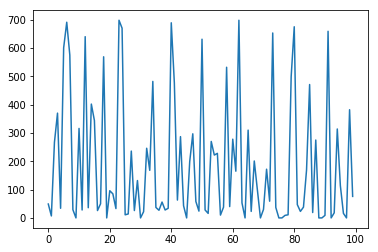

188.9

In [0]:
plt.plot(lower_bounds_winds)
plt.show()
np.mean(lower_bounds_winds)

### Линейная регрессия не на разностях

In [13]:
winds = np.array(range(2,20,1))
winds = np.append(winds, np.array(range(20,120,5)))
winds

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  25,  30,  35,  40,  45,  50,  55,
        60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115])

In [0]:
regr_mse = get_mse(winds)

##### ошибка

In [0]:
regr_mse[0]

1.1914692332405425

### Линейная регрессия на разностях

In [115]:
winds = np.array(range(2,20,1))
winds = np.append(winds, np.array(range(20,120,5)))

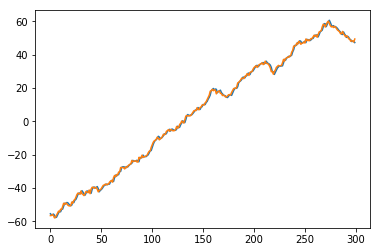

In [531]:
res = get_dif(1,winds, lin_regr, True)

In [119]:
regr_dif_mse = get_dif_mse(winds, lin_regr)

In [120]:
print("Linear regression: MSE={}+-{}, train_MSE={}, mean_wind={}".format(
    np.round(np.mean(regr_dif_mse[:,0]),3), np.round(2*np.var(regr_dif_mse[:,0]),3),
    np.round(np.mean(regr_dif_mse[:,1]),3), np.mean(regr_dif_mse[:,2])))

Linear regression: MSE=1.105+-0.035, train_MSE=1.098, mean_wind=13.74


In [533]:
print("Linear regression: MSE={}+-{}, train_MSE={}, mean_wind={}".format(
    np.round(np.mean(regr_dif_mse[:,0]),3), np.round(2*np.var(regr_dif_mse[:,0]),3),
    np.round(np.mean(regr_dif_mse[:,1]),3), np.mean(regr_dif_mse[:,2])))

Linear regression: MSE=1.117+-0.038, train_MSE=1.112, mean_wind=13.29


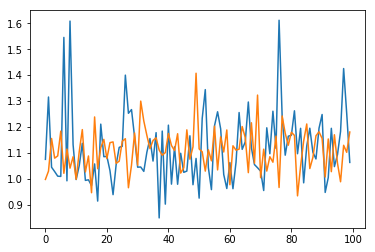

In [534]:
plt.plot(regr_dif_mse[:,0])
plt.plot(regr_dif_mse[:,1])
plt.show()

In [535]:
regr_dif_mse[:,2].astype('int')

array([13, 40, 14, 18,  9, 19,  2, 17,  3, 13, 12, 13,  8, 11,  8, 17, 16,
        5,  8, 17, 18, 11, 14, 16,  2, 25,  6, 10,  2, 13, 10, 30, 18, 40,
       17, 17,  7, 10, 14,  7, 55,  2, 11, 10, 18, 35, 10,  5, 10, 25,  2,
       14, 17, 25, 19,  8,  4, 13, 14, 18, 20, 12, 13, 13, 18,  2,  6,  5,
       12, 11,  2, 25,  4, 11, 18, 12,  2, 15, 14,  9, 18,  3,  2, 17, 14,
        6, 14,  6,  8, 13, 19,  9, 30, 20,  6,  3, 25,  2, 11, 14])

In [537]:
arr_name.append('Lin regr')
arr_train.append(np.round(np.mean(regr_dif_mse[:,1]),3))
arr_test.append(np.round(np.mean(regr_dif_mse[:,0]),3))
arr_var.append(np.round(np.var(regr_dif_mse[:,0]),3))

### Lasso  на разностях

In [538]:
lasso_dif_mse = get_dif_mse(winds, lasso)

In [545]:
print("Lasso: MSE={}+-{}, train_MSE={}, mean_wind={}, mean_alpha={}".format(
    np.round(np.mean(lasso_dif_mse[:,0]),3), np.round(2*np.var(lasso_dif_mse[:,0]),3),
    np.round(np.mean(lasso_dif_mse[:,1]),3), np.mean(lasso_dif_mse[:,2]), 
    np.round(np.mean(lasso_dif_mse[:,3]), 3)))

Lasso: MSE=1.12+-0.041, train_MSE=1.093, mean_wind=45.24, mean_alpha=0.039


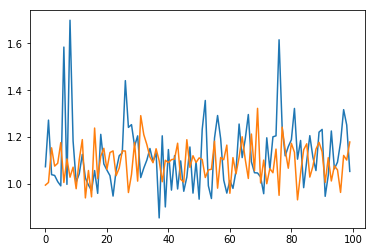

In [546]:
plt.plot(lasso_dif_mse[:,0])
plt.plot(lasso_dif_mse[:,1])
plt.show()

In [547]:
lasso_dif_mse[:,2].astype('int')

array([ 17,  65,  95,  18,   9,  19,   5,  40,  95,  40,  35,  13,  50,
       115,  80,  17,  16, 110,   8,  17,  30,  16,  14, 105,   2,  25,
        30,  10,  85,  13, 100,  30,  30,  40,  17, 105,  17,  60, 105,
         7,  70,  85,  16,  10,  18, 115,  10,  14,  35, 115,  18,  14,
        17, 115,  19,  50, 110,  55,  14,  55,  90,  90,  70,  13,  18,
        65,   6,  60,  30,  11,   2,  25, 105,  30,  60,  90,  45,  15,
        25,  70,  25, 105,   5,  25,  14, 115,  45, 100, 115,  25,  19,
         9, 110,  30, 115,   3,  50,   9,  11,  14])

In [548]:
arr_name.append('Lasso')
arr_train.append(np.round(np.mean(lasso_dif_mse[:,1]),3))
arr_test.append(np.round(np.mean(lasso_dif_mse[:,0]),3))
arr_var.append(np.round(np.var(lasso_dif_mse[:,0]),3))

### Tree  на разностях

In [540]:
tree_dif_mse = get_dif_mse(winds, tree)

In [541]:
print("Tree: MSE={}+-{}, train_MSE={}, mean_wind={}, mean_depth={}".format(
    np.round(np.mean(tree_dif_mse[:,0]),3), np.round(2*np.var(tree_dif_mse[:,0]),3),
    np.round(np.mean(tree_dif_mse[:,1]),3), np.mean(tree_dif_mse[:,2]), 
    np.round(np.mean(tree_dif_mse[:,3]), 3)))

Tree: MSE=1.238+-0.075, train_MSE=1.176, mean_wind=38.6, mean_depth=1.49


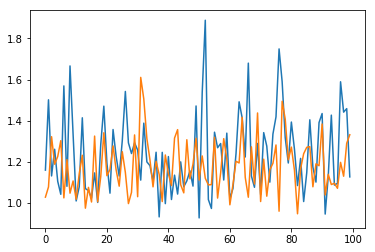

In [549]:
plt.plot(tree_dif_mse[:,0])
plt.plot(tree_dif_mse[:,1])
plt.show()

In [550]:
print(tree_dif_mse[:,2].astype('int'))

[  5 110  95   8   3  18  15  90   4  25   2  12  60 100  70 115   7 110
   2  20  90   8  12 110   2  30   3 115   2   2 115  17   6 100   2 100
   6   2 105   3  50  85   6   3  20   8   2   2  90 115 115   5  40 105
  17   6 110   8   9 110  10 115  75   7  90 110   2   4  25  17   2  80
  17  14   2  11  45  75   5   5  16 105   2  12   8   3   6 100   8   4
   4   4 115   7 115   3   7   6  14   3]


In [551]:
arr_name.append('Tree')
arr_train.append(np.round(np.mean(tree_dif_mse[:,1]),3))
arr_test.append(np.round(np.mean(tree_dif_mse[:,0]),3))
arr_var.append(np.round(np.var(tree_dif_mse[:,0]),3))

### Boosting  на разностях

In [552]:
winds_boost = np.array(range(2,20,3))
winds_boost = np.append(winds_boost, np.array(range(20,141,15)))

In [555]:
boost_dif_mse = get_dif_mse(winds_boost, boost)

In [556]:
print("Tree: MSE={}+-{}, train_MSE={}, mean_wind={}, mean_estim={}, mean_depth={}".format(
    np.round(np.mean(boost_dif_mse[:,0]),3), np.round(2*np.var(boost_dif_mse[:,0]),3),
    np.round(np.mean(boost_dif_mse[:,1]),3), np.mean(boost_dif_mse[:,2]), 
    np.round(np.mean(boost_dif_mse[:,3]), 3), np.round(np.mean(boost_dif_mse[:,4]), 3)))

Tree: MSE=1.148+-0.043, train_MSE=1.111, mean_wind=54.71, mean_estim=45.6, mean_depth=1.56


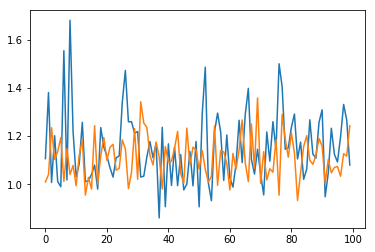

In [557]:
plt.plot(boost_dif_mse[:,0])
plt.plot(boost_dif_mse[:,1])
plt.show()

In [558]:
print(boost_dif_mse[:,2].astype('int'))

[ 14  65 140  11   8  20   2  50   2  20  35  65  11 125  80 125  17 110
   8  14  95  17  17 110  17  80  20  35  95  17 110  17  35  80  17 110
  35 125 140   8  95  80  20  20  17 110  14   5  17 140 140  14  11 140
  17   8 110  35  17 140  20 125  65 140  80 140   5  65  11  11   2  35
 110  17  80  11 140  65  35  65  17  95   2  20  11 140  35 125 140  14
  20  20 140  11 125   2  50   8  14   8]


In [559]:
boost_dif_mse[:,3].astype('int')

array([ 60,  20,  20,  40,  40,  80,  40,  40,  40,  60,  20,  20,  60,
        20, 100,  20,  40,  20,  60,  60,  40,  20,  40, 100,  20,  20,
        20,  40,  20,  40,  20, 120, 120,  20,  60,  20,  60,  20,  20,
        80,  60,  40,  40,  40,  20,  60,  80,  60,  20, 100,  20, 120,
        40,  20, 100, 100,  20,  20,  40,  20,  20,  20,  60,  20,  80,
       100,  20,  20,  20,  80,  40,  40,  20,  20,  60,  20,  20,  60,
        40,  40, 100,  20,  20,  40, 120,  20,  20,  20,  20,  40,  20,
        40, 100, 100,  20,  20,  60,  20, 120,  60])

In [560]:
boost_dif_mse[:,4].astype('int')

array([1, 2, 3, 2, 2, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 3, 3, 2, 1, 2, 1, 1,
       2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2,
       3, 2, 1, 1, 3, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
       2, 2, 3, 1, 1, 3, 1, 3, 2, 3, 1, 2, 3, 2, 1, 1, 1, 3, 1, 2, 3, 1,
       2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1])

In [561]:
arr_name.append('XGBoost')
arr_train.append(np.round(np.mean(boost_dif_mse[:,1]),3))
arr_test.append(np.round(np.mean(boost_dif_mse[:,0]),3))
arr_var.append(np.round(np.var(boost_dif_mse[:,0]),3))

### Результаты

In [23]:
var = [0.019, 0.02, 0.037, 0.022]
var1 = list(map(lambda x : x**.5/10, var))
np.round(var1,3)

array([0.014, 0.014, 0.019, 0.015])

In [565]:
dic={'name':arr_name, 'train': arr_train, 'test': arr_test, 'var': arr_var}
df=pd.DataFrame(data=dic)
df

,name,train,test,var
0,Lin regr,1.112,1.117,0.019
1,Lasso,1.093,1.120,0.020
2,Tree,1.176,1.238,0.037
3,XGBoost,1.111,1.148,0.022
